<a href="https://colab.research.google.com/github/ohudalraddadi-hub/ai-arabic-text-detection/blob/main/Task_2_2_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q pandas numpy matplotlib ar_wordcloud arabic-reshaper python-bidi

In [ ]:
import re, regex as re2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from ar_wordcloud import ArabicWordCloud
import arabic_reshaper
from bidi.algorithm import get_display
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
# --- Load data ---
file_path = "/content/drive/MyDrive/Colab Notebooks/arabic_generated_abstracts_long_clean2.csv"
df = pd.read_csv(file_path)

## Statistical Analysis: Word, Sentence, and Vocabulary Metrics


In [ ]:
df = df.copy()
df['text_raw'] = df['text'].astype(str)

# Minimal normalization that KEEPS punctuation (for function words & sentence stats we don't strip stops)
_AR_DIACRITICS = re2.compile(r'[\u0610-\u061A\u064B-\u065F\u0670\u06D6-\u06ED]')
_TATWEEL = "\u0640"
def normalize_keep_punct(s: str) -> str:
    s = re.sub(r'[ٱآأإ]', 'ا', s).replace('ؤ','و').replace('ئ','ي').replace('ى','ي').replace(_TATWEEL,'')
    s = _AR_DIACRITICS.sub('', s)
    s = re.sub(r'\s+', ' ', s).strip()
    return s

df['text_norm_no_stop'] = df['text_raw'].apply(normalize_keep_punct)

# Map labels to names
label_map = {0: 'Human', 1: 'AI'}
df['label_name'] = df['label'].map(label_map)

# ---------------- tokenizers & splitters ----------------
AR_SENT_SPLIT = re.compile(r'[\.!\?؟…؛،]+')   # include Arabic comma/semicolon
AR_TOKEN_SPLIT = re.compile(r'\s+')

def ar_sentences(text: str):
    sents = [s.strip() for s in AR_SENT_SPLIT.split(text) if s.strip()]
    return sents if sents else ([text.strip()] if text.strip() else [])

def ar_tokens(text: str):
    return [t for t in AR_TOKEN_SPLIT.split(text) if t]

# ---------------- sets for lexical stats ----------------
AR_FUNCTION_WORDS = {
    # conjunctions
    'و','أو','ثم','لكن','بل','حتى','ف','كما','لأن','حيث','إذ','إلا',
    # prepositions
    'في','على','من','إلى','عن','ب','ك','ل','مع','بين','عند','قبل','بعد','تحت','فوق',
    # particles / modals / copulas (common)
    'قد','لم','لن','إن','أن','كان','ليس','ما','لا','هذا','هذه','ذلك','تلك','هناك','هنا'
}
AR_PUNCT_SET = set(list('،؛؟.!…:"()[]{}-—_,'))

def count_punct_chars(text: str):
    return sum(ch in AR_PUNCT_SET for ch in text)

def type_token_ratio(tokens):
    return (len(set(tokens)) / len(tokens)) if tokens else 0.0


In [ ]:
# ---------------- class-level stats ----------------
def class_stats(group: pd.DataFrame):
    # Sentence length & punctuation from RAW text
    raw_texts = group['text_raw'].tolist()
    sents_per_doc = [len(ar_sentences(t)) for t in raw_texts]
    words_per_sent = []
    for t in raw_texts:
        sents = ar_sentences(t)
        if sents:
            words_per_sent.extend([len(ar_tokens(s)) for s in sents])
    punct_total = sum(count_punct_chars(t) for t in raw_texts)
    char_total = sum(len(t) for t in raw_texts)

    # Lexical metrics (TTR, avg word len, function words) from normalized-no-stop-removal text
    norm_texts = group['text_norm_no_stop'].tolist()
    norm_tokens = [tok for txt in norm_texts for tok in ar_tokens(txt)]
    word_lengths = [len(t) for t in norm_tokens if t]
    func_count = sum(1 for t in norm_tokens if t in AR_FUNCTION_WORDS)
    func_ratio = func_count / max(1, len(norm_tokens))

    return pd.Series({
        'docs': len(raw_texts),
        'TTR_corpus': round(type_token_ratio(norm_tokens), 4),
        'avg_word_len': round(float(np.mean(word_lengths)) if word_lengths else 0.0, 3),
        'avg_sent_len_words': round(float(np.mean(words_per_sent)) if words_per_sent else 0.0, 3),
        'function_word_ratio': round(func_ratio, 4),
        'punct_per_1000_chars': round(1000.0 * punct_total / max(1, char_total), 2)
    })

stats_by_class = df.groupby('label_name').apply(class_stats)
display(stats_by_class)

# -------- Mean doc-level TTR (less length-biased) --------
def doc_ttr(text: str):
    toks = ar_tokens(text)
    return type_token_ratio(toks)

mean_doc_TTR = (
    df.assign(doc_TTR=df['text_norm_no_stop'].map(doc_ttr))
      .groupby('label_name')['doc_TTR']
      .mean()
      .round(4)
      .to_frame('mean_doc_TTR')
)
display(mean_doc_TTR)

/tmp/ipython-input-1094730785.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stats_by_class = df.groupby('label_name').apply(class_stats)


,docs,TTR_corpus,avg_word_len,avg_sent_len_words,function_word_ratio,punct_per_1000_chars
label_name,,,,,,
AI,33552.0,0.0330,5.429,10.508,0.1161,16.17
Human,8388.0,0.0626,5.179,12.205,0.1231,17.22


,mean_doc_TTR
label_name,
AI,0.7922
Human,0.8110


* Lexical diversity: Human higher on both corpus TTR (0.0626 vs 0.0330) and mean doc-TTR (0.8110 vs 0.7922) → humans use a wider vocabulary.

* Sentence length: Human longer (12.21 vs 10.51 words/sentence) → AI tends to write shorter, more regular sentences.

* Function words: Human higher (0.1231 vs 0.1161) → humans rely slightly more on discourse glue (e.g., في/على/ومن/إن/أن/كان…).

* Punctuation density: Human higher (17.22 vs 16.17 per 1k chars) → humans use more punctuation and rhythm marks.

* Word length: AI a bit longer on average (5.43 vs 5.18 chars) → suggests heavier/learned vocabulary or compound/nominal style in AI.

/tmp/ipython-input-946572364.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  split_stats = df.groupby(['split_name','label_name']).apply(class_stats)


docs  TTR_corpus  avg_word_len  \
split_name             label_name                                      
by_polishing           AI          11404.0      0.0632         5.396   
                       Human        2851.0      0.1779         5.181   
from_title             AI          11852.0      0.0434         5.498   
                       Human        2963.0      0.1759         5.178   
from_title_and_content AI          10296.0      0.0643         5.397   
                       Human        2574.0      0.1846         5.177   

                                   avg_sent_len_words  function_word_ratio  \
split_name             label_name                                            
by_polishing           AI                      10.138               0.1191   
                       Human                   12.219               0.1231   
from_title             AI                      11.467               0.1169   
                       Human                   12.208               0.1231   
from_title_and_content AI                      10.093               0.1118   
                       Human                   12.188               0.1232   

                                   punct_per_1000_chars  
split_name             label_name                        
by_polishing           AI                         16.80  
                       Human                      17.19  
from_title             AI                         14.27  
                       Human                      17.25  
from_title_and_content AI                         17.38  
                       Human                      17.23

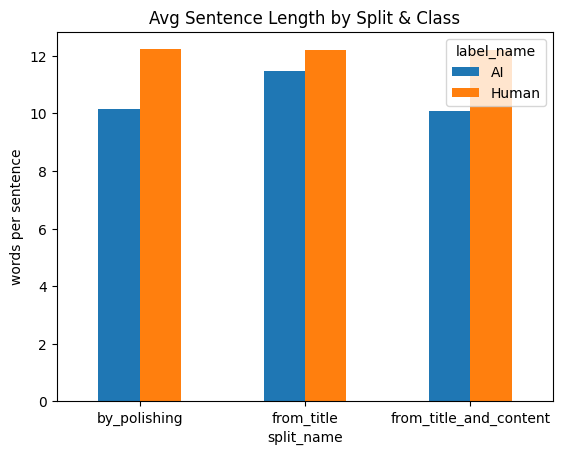

In [ ]:
# -----------------------------------------------------------
# Split-aware stats: see differences by generation method
# -----------------------------------------------------------
split_stats = df.groupby(['split_name','label_name']).apply(class_stats)
display(split_stats)

# quick visual: average sentence length by split & class
pivot_len = split_stats['avg_sent_len_words'].unstack()
pivot_len.plot(kind='bar', title='Avg Sentence Length by Split & Class', rot=0)
plt.ylabel('words per sentence')
plt.show()

## EDA Visualization : Word Clouds and Top n-grams

Word Clouds per class

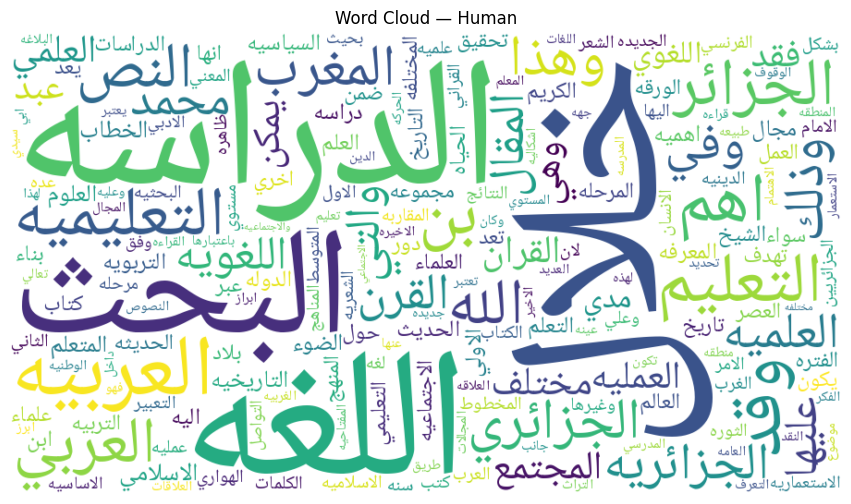

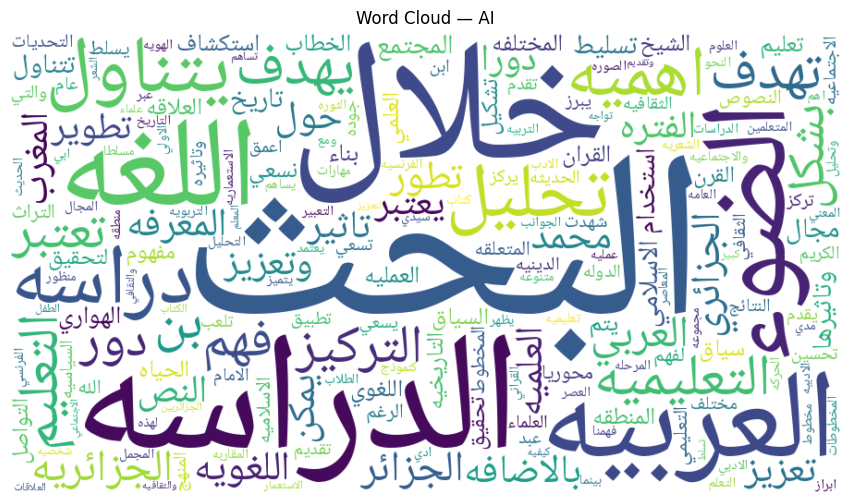

In [ ]:
def wordcloud_for(label_name, max_chars=300_000):
    # pull the series safely
    s = df.loc[df["label_name"] == label_name, 'text_clean']

    # drop NaN, cast to str, strip, remove empties and the literal "nan"
    s = (s.dropna()
           .astype(str)
           .map(lambda x: x.strip())
           .loc[lambda x: x.str.len() > 0]
           .loc[lambda x: x.str.lower() != "nan"])

    # join; optionally cap size to avoid huge concatenations
    text = " ".join(s.tolist())
    if len(text) > max_chars:
        text = text[:max_chars]

    wc = ArabicWordCloud(
        width=900, height=500,
        background_color="white",
        collocations=False
        # don't pass font_path here; ArabicWordCloud sets it internally
    ).generate(text)

    plt.figure(figsize=(12, 6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud — {label_name}")
    plt.show()

# draw clouds
wordcloud_for("Human")
wordcloud_for("AI")


 Top n-grams (uni/bi/tri) per class

In [ ]:
# -----------------------------------------------------------
# Top n-grams (uni/bi/tri) per class
# -----------------------------------------------------------
def top_ngrams(series, n=1, top_k=20):
    vec = CountVectorizer(
        analyzer='word',
        ngram_range=(n, n),
        max_features=50000,
        token_pattern=r'(?u)\b\w+\b',
        lowercase=False
    )
    X = vec.fit_transform(series.astype(str))
    freqs = np.asarray(X.sum(axis=0)).ravel()
    vocab = np.array(vec.get_feature_names_out())
    top = (pd.DataFrame({'ngram': vocab, 'freq': freqs})
           .sort_values('freq', ascending=False)
           .head(top_k)
           .reset_index(drop=True))
    return top

for n in (1,2,3):
    print(f'\n=== Top {20} {n}-grams — Human ===')
    display(top_ngrams(df[df['label_name']=='Human']['text_clean'], n=n, top_k=20))
    print(f'\n=== Top {20} {n}-grams — AI ===')
    display(top_ngrams(df[df['label_name']=='AI']['text_clean'], n=n, top_k=20))


=== Top 20 1-grams — Human ===


,ngram,freq
0,الدراسه,5601
1,خلال,4448
2,البحث,2350
3,الجزائر,2038
4,وقد,2037
5,العربيه,1838
6,الجزائري,1680
7,وذلك,1613
8,اهم,1609
9,اللغه,1451



=== Top 20 1-grams — AI ===


,ngram,freq
0,البحث,40247
1,الدراسه,38378
2,خلال,21850
3,تحليل,13085
4,النتائج,12961
5,تهدف,11834
6,اهميه,10355
7,الجزائر,10196
8,دراسه,10166
9,التركيز,9618



=== Top 20 2-grams — Human ===


,ngram,freq
0,تهدف الدراسه,766
1,الورقه البحثيه,569
2,اللغه العربيه,528
3,المنهج الوصفي,504
4,الكلمات المفتاحيه,471
5,هدفت الدراسه,461
6,المشرع الجزائري,452
7,وذلك خلال,346
8,توصلت الدراسه,308
9,تسليط الضوء,295



=== Top 20 2-grams — AI ===


,ngram,freq
0,تهدف الدراسه,8596
1,يهدف البحث,6832
2,الورقه البحثيه,4684
3,يتناول البحث,4093
4,اللغه العربيه,3299
5,الدراسه تحليل,3059
6,البحث دراسه,3045
7,النتائج المتوقعه,3035
8,تشير النتائج,3013
9,الدراسه استكشاف,2979



=== Top 20 3-grams — Human ===


,ngram,freq
0,المنهج الوصفي التحليلي,193
1,فروق دلاله احصائيه,173
2,التربيه البدنيه والرياضيه,145
3,المؤسسات الصغيره والمتوسطه,133
4,تهدف الورقه البحثيه,132
5,تهدف الدراسه التعرف,117
6,هدفت الدراسه التعرف,111
7,تهدف الدراسه ابراز,102
8,وقد توصلت الدراسه,98
9,الدراسه تسليط الضوء,92



=== Top 20 3-grams — AI ===


,ngram,freq
0,تهدف الدراسه استكشاف,2389
1,تهدف الدراسه تحليل,2120
2,يهدف البحث دراسه,1651
3,تدرس الورقه البحثيه,1600
4,يسلط البحث الضوء,1352
5,تسلط الدراسه الضوء,1187
6,لتحقيق الهدف سيتم,1108
7,الهدف سيتم استخدام,1096
8,تستخدم الدراسه منهجا,1078
9,سيتم استخدام منهج,938


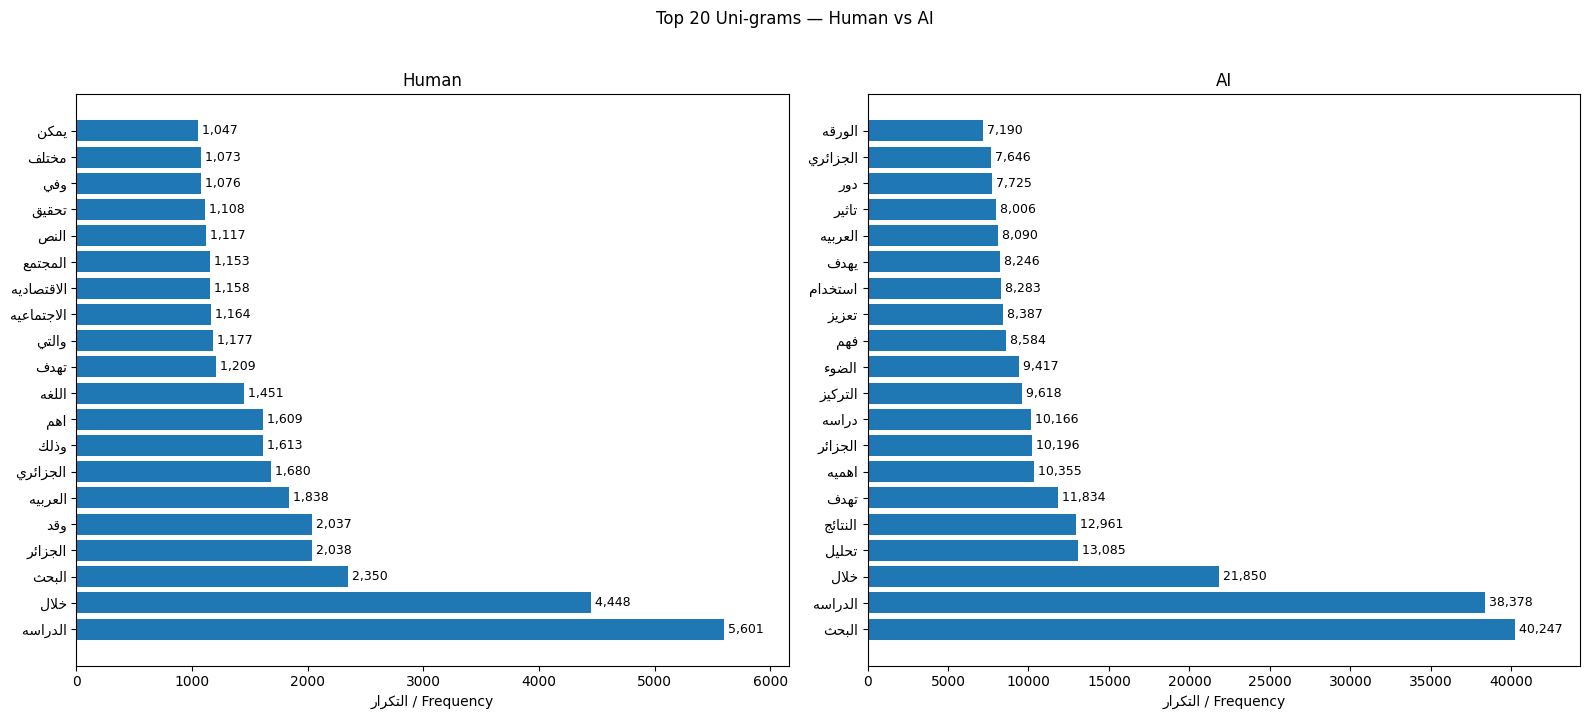

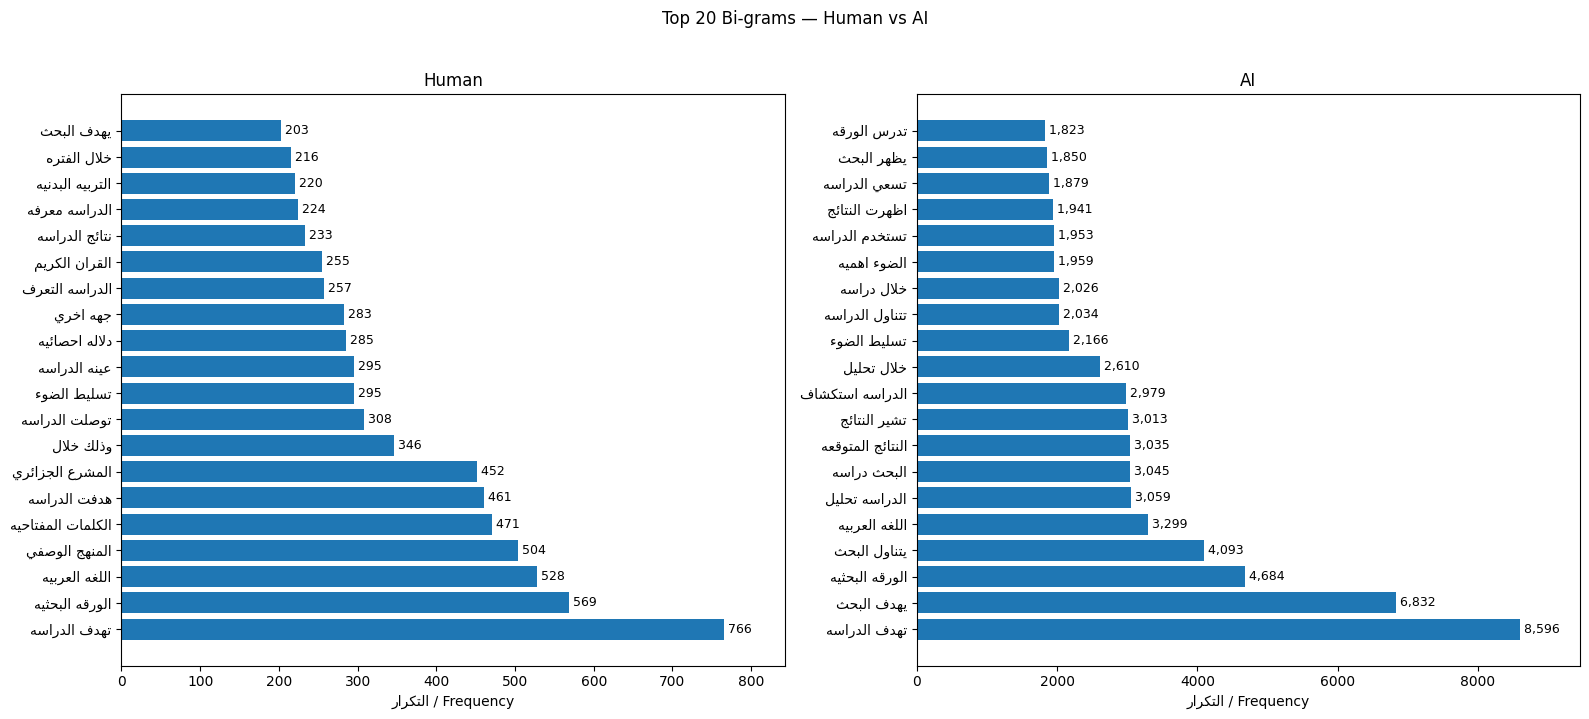

/tmp/ipython-input-3687003521.py:44: UserWarning: Glyph 65010 (\N{ARABIC LIGATURE ALLAH ISOLATED FORM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65010 (\N{ARABIC LIGATURE ALLAH ISOLATED FORM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


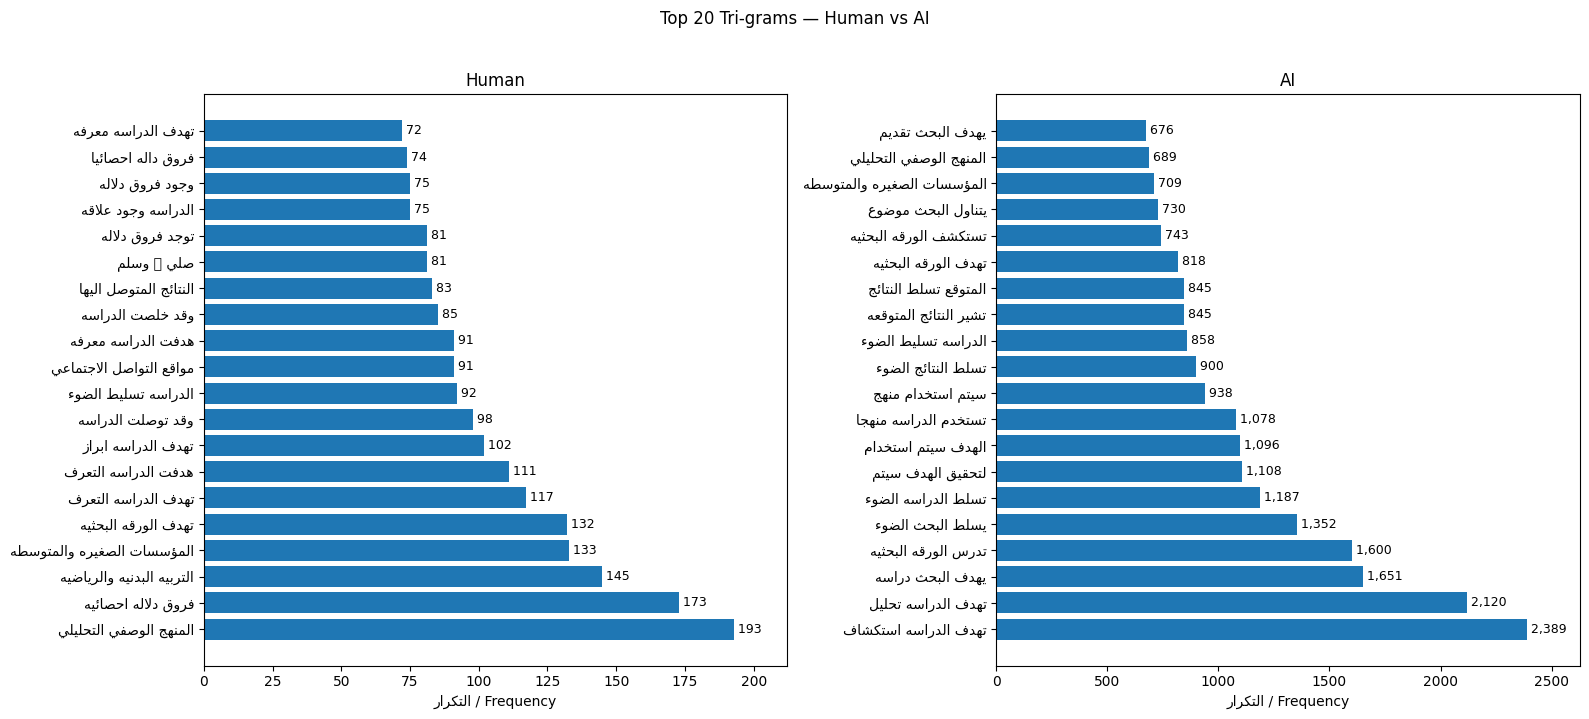

In [ ]:
#Helpers to shape & reorder Arabic
def ar_shape(text: str) -> str:
    if not isinstance(text, str):
        text = str(text)
    # reshape letters (ligatures) then apply bidi (RTL order)
    return get_display(arabic_reshaper.reshape(text))

def plot_pair_ngrams(df_in, n=1, top_k=20, text_col="text_clean"):
    series_h = df_in[df_in["label_name"]=="Human"][text_col].astype(str)
    series_a = df_in[df_in["label_name"]=="AI"][text_col].astype(str)

    top_h = top_ngrams(series_h, n=n, top_k=top_k)
    top_a = top_ngrams(series_a, n=n, top_k=top_k)

    fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharex=False)
    fig.suptitle(f"Top {top_k} {['Uni','Bi','Tri'][n-1]}-grams — Human vs AI", y=1.02)

    def draw(ax, df_top, title_en):
        y_raw = df_top["ngram"][::-1]
        x = df_top["freq"][::-1]

        # Shape Arabic labels
        y_shaped = [ar_shape(lbl) for lbl in y_raw]

        bars = ax.barh(range(len(y_shaped)), x)
        ax.set_yticks(range(len(y_shaped)))
        ax.set_yticklabels(y_shaped, ha="right")

        ax.invert_yaxis()
        ax.set_title(title_en)
        ax.set_xlabel(ar_shape("التكرار") + " / Frequency")

        # Annotate numeric frequencies on bars (to the right), shape not needed for numbers
        for rect, val in zip(bars, x):
            ax.text(val, rect.get_y() + rect.get_height()/2, f" {int(val):,}",
                    va="center", ha="left", fontsize=9)

        xmax = max(x) if len(x) else 0
        ax.set_xlim(0, xmax * 1.10 if xmax else 1)

    draw(axes[0], top_h, "Human")
    draw(axes[1], top_a, "AI")

    plt.tight_layout()
    plt.show()

for n in (1, 2, 3):
    plot_pair_ngrams(df, n=n, top_k=20, text_col="text_clean")
